In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow

In [2]:
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [6]:
from typeguard import typechecked
from typing import Optional

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [15]:
train_dataset  = train_datagen.flow_from_directory(directory = 'D:\\Projects\\Cap Pro\\Dataset\\train',
                                                   target_size = (331,331),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [16]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'D:\\Projects\\Cap Pro\\Dataset\\train',
                                                  target_size = (331,331),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


In [17]:
test_dataset = test_datagen.flow_from_directory(directory = 'D:\\Projects\\Cap Pro\\Dataset\\test',
                                                target_size = (331,331),
                                                class_mode = 'categorical',
                                                batch_size = 64)

Found 1279 images belonging to 4 classes.


In [18]:
base_model = tf.keras.applications.NASNetLarge(input_shape = (331,331,3), include_top = False, weights = "imagenet")

343610240/343610240 [==============================] - 55s 0us/step


In [19]:
#Freezing Layers
for layer in base_model.layers[:-3]:
    layer.trainable=False

In [20]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 dropout (Dropout)           (None, 11, 11, 4032)      0         
                                                                 
 flatten (Flatten)           (None, 487872)            0         
                                                                 
 batch_normalization (BatchN  (None, 487872)           1951488   
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                15611936  
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [22]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [23]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),  
    tf.keras.metrics.AUC(name = 'auc'),
    f1_score]

In [24]:
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 20,verbose = 1, factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [25]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)

In [26]:
history = model.fit(train_dataset,validation_data = valid_dataset,epochs = 5,verbose = 1,callbacks = [lrd,mcp,es])
history

Epoch 1/5
65/65 [==============================] - 1934s 30s/step - loss: 1.4099 - accuracy: 0.7320 - precision: 0.3310 - recall: 0.0705 - auc: 0.6076 - f1_score: 0.1125 - val_loss: 1.1857 - val_accuracy: 0.7551 - val_precision: 0.8621 - val_recall: 0.0244 - val_auc: 0.7705 - val_f1_score: 0.0466 - lr: 0.0010
Epoch 2/5
65/65 [==============================] - 1795s 28s/step - loss: 1.1483 - accuracy: 0.7553 - precision: 0.5275 - recall: 0.2033 - auc: 0.7580 - f1_score: 0.2966 - val_loss: 1.1195 - val_accuracy: 0.7603 - val_precision: 0.6694 - val_recall: 0.0811 - val_auc: 0.7808 - val_f1_score: 0.1419 - lr: 0.0010
Epoch 3/5
65/65 [==============================] - 1816s 28s/step - loss: 1.0738 - accuracy: 0.7631 - precision: 0.5521 - recall: 0.2765 - auc: 0.7843 - f1_score: 0.3620 - val_loss: 1.0699 - val_accuracy: 0.7652 - val_precision: 0.6505 - val_recall: 0.1310 - val_auc: 0.7861 - val_f1_score: 0.2151 - lr: 0.0010
Epoch 4/5
65/65 [==============================] - 1822s 28s/step -

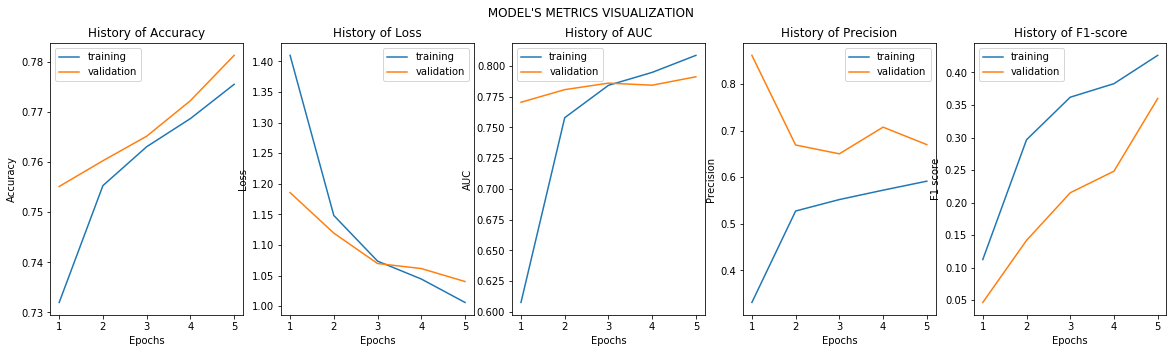

In [28]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score'])